In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
all_data = pd.read_excel("systema_all.xlsx")

In [3]:
all_data.shape

(111120, 8)

Для анализа сессий отберем данные о входе и выходе из приложения. Будем считать, что корректно залогированные сессии должны начинаться с захода в приложение и заканчиваться выходом из него.

In [4]:
data = all_data.query("session_id != -1 and (event_type == 'application-quit' or event_type == 'application-start')")

In [5]:
data.head()

,device_id,event_properties,event_time,event_type,platform,session_id,user_id,user_properties
7,b43d63ff-5d80-56e0-8580-76cd4c941ee8,{},2022-04-17 10:05:55.250,application-quit,WindowsEditor,6.378579e+17,2680ebc9e09583018919983fe1364cf196e1e0a1,{'email': 'DEV1'}
8,b43d63ff-5d80-56e0-8580-76cd4c941ee8,{},2022-04-17 10:00:36.945,application-start,WindowsEditor,6.378579e+17,2680ebc9e09583018919983fe1364cf196e1e0a1,{'email': 'DEV1'}
21,b43d63ff-5d80-56e0-8580-76cd4c941ee8,{},2022-04-17 10:04:43.039,application-quit,WindowsEditor,6.378579e+17,2680ebc9e09583018919983fe1364cf196e1e0a1,{'email': 'DEV1'}
22,b43d63ff-5d80-56e0-8580-76cd4c941ee8,{},2022-04-17 10:04:48.086,application-start,WindowsEditor,6.378579e+17,2680ebc9e09583018919983fe1364cf196e1e0a1,{'email': 'DEV1'}
33,b43d63ff-5d80-56e0-8580-76cd4c941ee8,{},2022-04-17 10:11:40.454,application-start,WindowsEditor,6.378579e+17,2680ebc9e09583018919983fe1364cf196e1e0a1,{'email': 'DEV1'}


Сгруппируем данные по сессиям и вычислим продолжительность каждой из них

In [6]:
sessions_data = data.groupby(["session_id", "platform"], as_index = False).agg({"event_time" : lambda x: x.max() - x.min()}) \
    .rename(columns = {"event_time" : "session_duration"})

In [7]:
sessions_data.head()

,session_id,platform,session_duration
0,6.378579e+17,WindowsEditor,0 days 01:17:13.793000
1,6.378589e+17,WindowsEditor,0 days 00:01:42.799000
2,6.378589e+17,WindowsEditor,0 days 00:01:57.712000
3,6.378589e+17,WindowsEditor,0 days 00:06:30.005000
4,6.378590e+17,WindowsEditor,0 days 00:00:23.287000


In [8]:
sessions_data["duration_in_minutes"] = sessions_data["session_duration"] / np.timedelta64(60, 's')

In [9]:
sessions_data.head()

,session_id,platform,session_duration,duration_in_minutes
0,6.378579e+17,WindowsEditor,0 days 01:17:13.793000,77.229883
1,6.378589e+17,WindowsEditor,0 days 00:01:42.799000,1.713317
2,6.378589e+17,WindowsEditor,0 days 00:01:57.712000,1.961867
3,6.378589e+17,WindowsEditor,0 days 00:06:30.005000,6.500083
4,6.378590e+17,WindowsEditor,0 days 00:00:23.287000,0.388117


In [10]:
sessions_data.dtypes

session_id                     float64
platform                        object
session_duration       timedelta64[ns]
duration_in_minutes            float64
dtype: object

Для упрощения процесса построения графика оставим только количество полных минут

In [11]:
sessions_data["clear_minutes_duration"] = sessions_data["duration_in_minutes"].astype(int)

In [12]:
sessions_data.head()

,session_id,platform,session_duration,duration_in_minutes,clear_minutes_duration
0,6.378579e+17,WindowsEditor,0 days 01:17:13.793000,77.229883,77
1,6.378589e+17,WindowsEditor,0 days 00:01:42.799000,1.713317,1
2,6.378589e+17,WindowsEditor,0 days 00:01:57.712000,1.961867,1
3,6.378589e+17,WindowsEditor,0 days 00:06:30.005000,6.500083,6
4,6.378590e+17,WindowsEditor,0 days 00:00:23.287000,0.388117,0


In [13]:
sessions_data.shape

(2561, 5)

Построим график распределения продолжительности сессий

In [14]:
sns.set(rc={'figure.figsize':(17,8.27)})

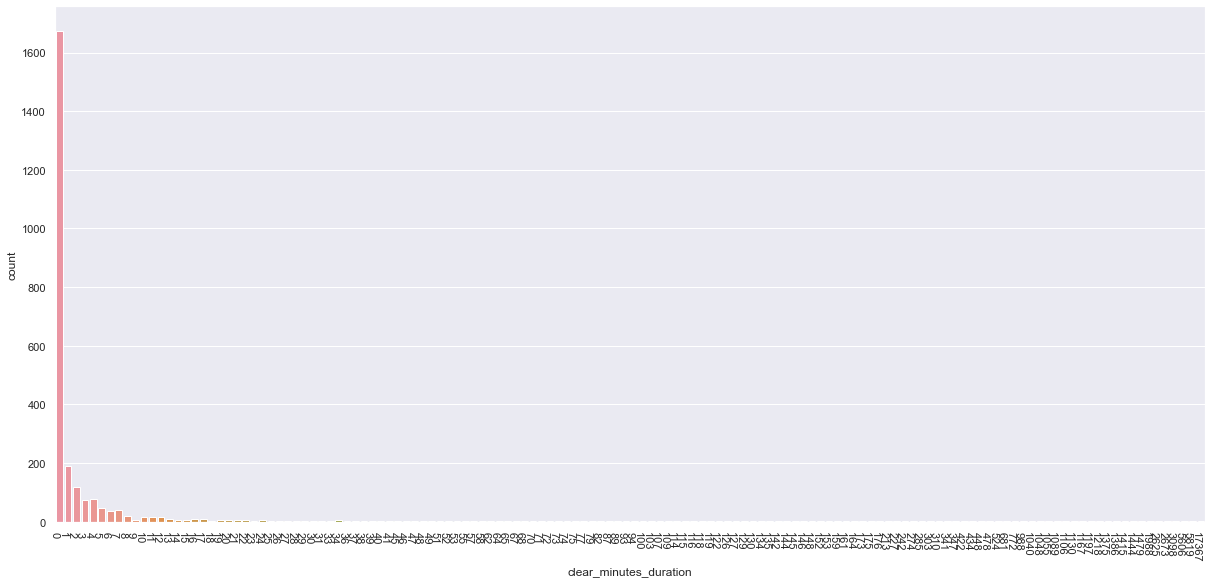

In [32]:
ax = sns.countplot(x = sessions_data.clear_minutes_duration, data = sessions_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90, ha="right")
plt.tight_layout()
plt.show()

Как видно из графика, подавлябщее большинство сессий длилось менее 10 минут. Рассмотрим их детальнее

<AxesSubplot:xlabel='clear_minutes_duration', ylabel='count'>

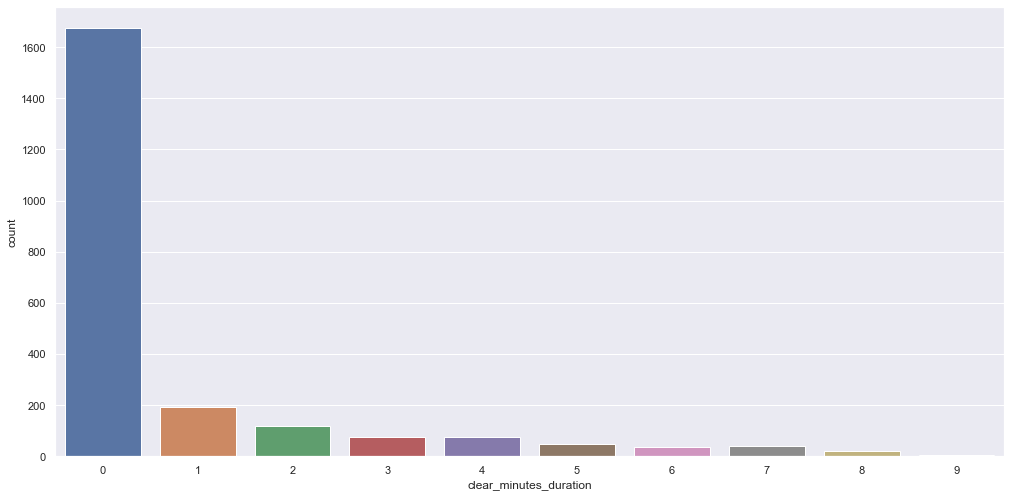

In [16]:
small_data = sessions_data.query("clear_minutes_duration < 10")
sns.countplot(x = small_data.clear_minutes_duration, data = small_data)

<AxesSubplot:xlabel='clear_minutes_duration', ylabel='Density'>

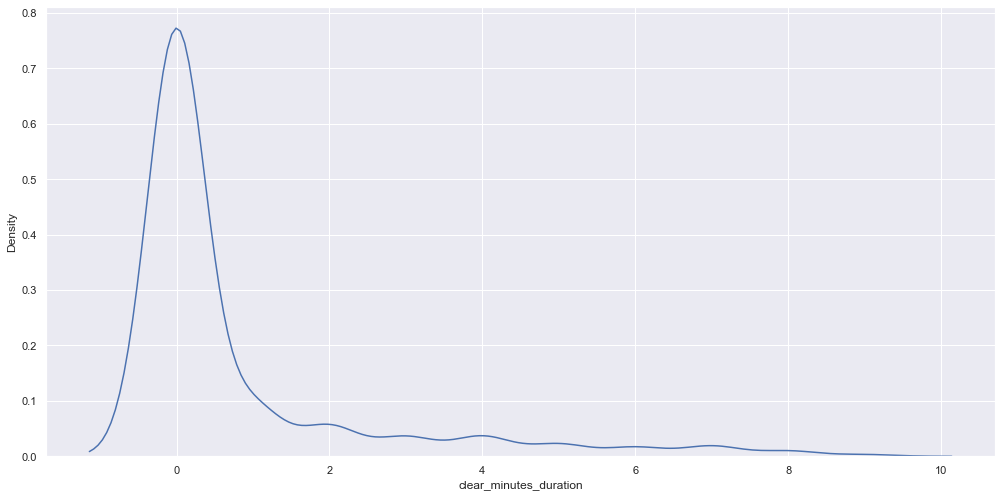

In [17]:
sns.kdeplot(small_data.clear_minutes_duration)

Более 75% сессий длились не более минуты. Посмотрим, что делали пользователи в эти сессии

In [18]:
fast_sessions_id = sessions_data.query("clear_minutes_duration < 1").session_id.to_list()
fast_sessions_data = all_data.query("session_id in @fast_sessions_id")
fast_sessions_data.head()

,device_id,event_properties,event_time,event_type,platform,session_id,user_id,user_properties
3092,ee39dfd7-5d4a-52c2-b8b7-e1a07d880bc1,{'OS': 'Android OS 11 / API-30 (RKQ1.201022.00...,2022-04-18 16:48:36.657,successed-sign-in,Android,6.378590e+17,74a05472c286c07c996f48ca3981ef0d,{'email': 'DEV1'}
3093,ee39dfd7-5d4a-52c2-b8b7-e1a07d880bc1,{'fps': 69},2022-04-18 16:48:39.998,average-fps,Android,6.378590e+17,74a05472c286c07c996f48ca3981ef0d,{'email': 'DEV1'}
3094,ee39dfd7-5d4a-52c2-b8b7-e1a07d880bc1,{'CourseName': 'Нервная система'},2022-04-18 16:48:43.508,lecture-mode-open,Android,6.378590e+17,74a05472c286c07c996f48ca3981ef0d,{'email': 'DEV1'}
3095,ee39dfd7-5d4a-52c2-b8b7-e1a07d880bc1,{'ActorName': 'nervhuman'},2022-04-18 16:49:15.239,actor-change,Android,6.378590e+17,74a05472c286c07c996f48ca3981ef0d,{'email': 'DEV1'}
3096,ee39dfd7-5d4a-52c2-b8b7-e1a07d880bc1,{},2022-04-18 16:49:18.697,go-to-atlas,Android,6.378590e+17,74a05472c286c07c996f48ca3981ef0d,{'email': 'DEV1'}


Уберем служебные события

In [19]:
#предполагался срез списка с N наиболее частыми событиями
most_popular_events = fast_sessions_data.query("event_type != 'average-fps'").value_counts("event_type").index.to_list()

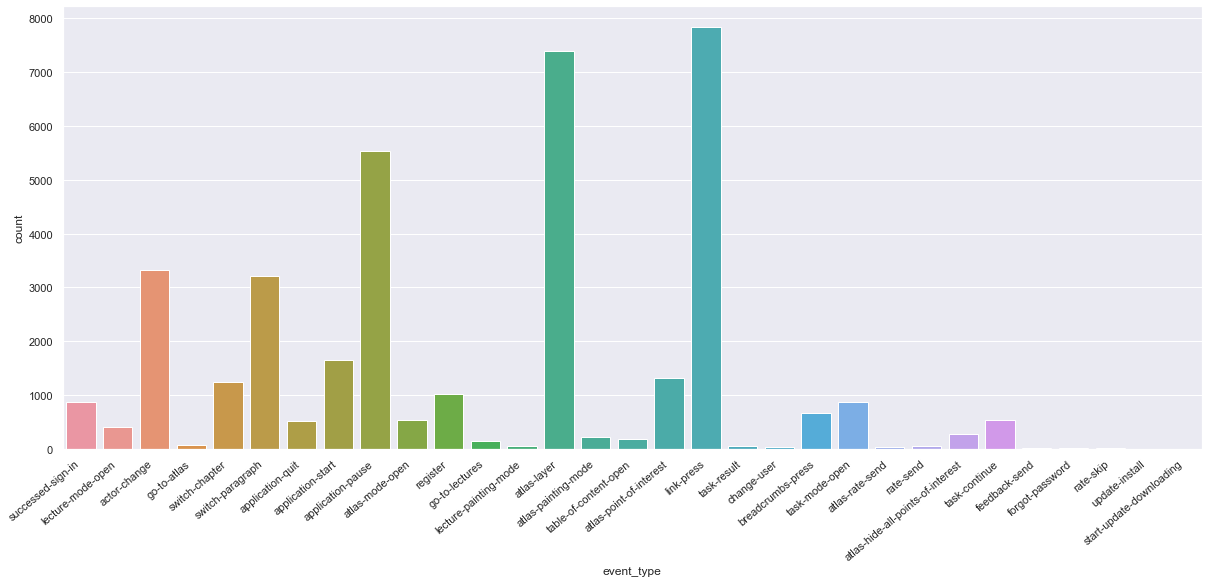

In [20]:
event_data = fast_sessions_data.query("event_type in @most_popular_events")
ax = sns.countplot(x = event_data.event_type)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Попробуем выделить события, которые будут иметь практическую ценность

<AxesSubplot:xlabel='event_type', ylabel='count'>

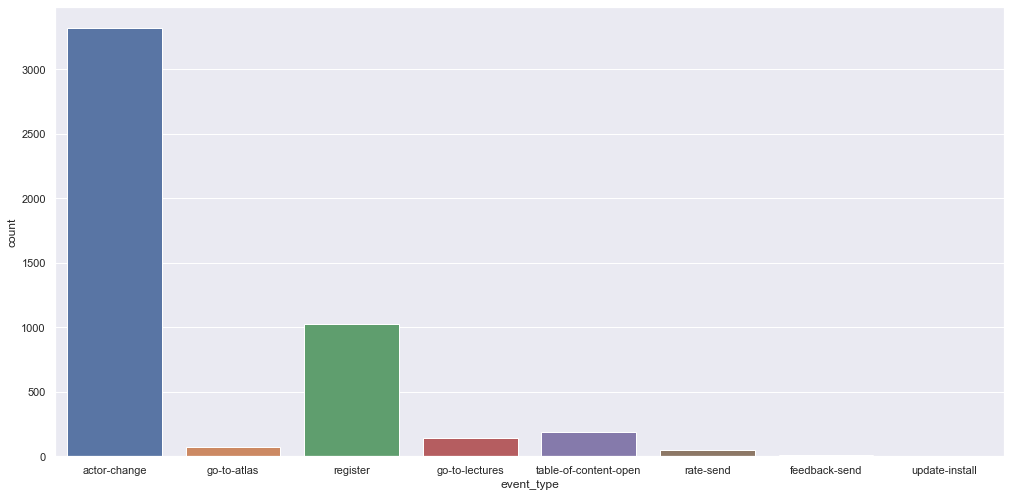

In [21]:
useful_events = ['go-to-lectures', 'actor-change', 'update-install', 'feedback-send', 'rate-send', 'go-to-atlas','table-of-content-open',  'register']
useful_event_data = fast_sessions_data.query("event_type in @useful_events")
sns.countplot(x = useful_event_data.event_type)

Правильно выбрав события, можно отследить, что именно делают пользователи во время коротких сессий. Также стоит учитывать, что некоторые действия могут повторяться много раз подряд - например переключение слоев в атласе, поэтому необходимо брать только основные метрики - "переключение на атлас", "переключение на лекции" и т.п. 

Я не смог понять смысл некоторых событий. Возможно, стоило выбрать другие event'ы. По графикам, пользователи чаще всего нажимают на какую-то ссылку, меняют курс (или что такое actor). 

________________________________________________________________________

Отберем пользователей, просидевших в приложении больше 10 минут

In [33]:
users_data = data.groupby(["user_id"], as_index = False).agg({"event_time" : lambda x: x.max() - x.min()}) \
    .rename(columns = {"event_time" : "all_sessions_duration"})

users_data["duration_in_minutes"] = users_data["all_sessions_duration"] / np.timedelta64(60, 's')
users_data["clear_minutes_duration"] = users_data["duration_in_minutes"].astype(int)

Всего 807 пользователей

In [23]:
users_data.shape

(807, 4)

In [34]:
users_data.head()

,user_id,all_sessions_duration,duration_in_minutes,clear_minutes_duration
0,002a400250bc792202f3978bd54ab0d5,2 days 02:59:05.609000,3059.093483,3059
1,00D3B387-376B-4A46-8776-5F25EF289A36,9 days 02:54:35.693000,13134.594883,13134
2,013D5507-83D9-4410-B652-934AAF06FBFA,16 days 23:19:58.637000,24439.977283,24439
3,017A3AB3-3AF9-4013-A077-5B9C084A9DAA,0 days 00:00:00,0.000000,0
4,01DEE4E9-19AB-4DC6-984B-D3594397C1A5,0 days 00:03:26.947000,3.449117,3


Примерно половина пользователей (465 из 807) провели в приложении больше 10 минут

In [25]:
users_id = users_data.query("clear_minutes_duration >= 10").user_id.to_list()
print(len(users_id))

465


При этом 50% пользователей просидели дольше 34 минут

In [26]:
users_data.clear_minutes_duration.describe()

count      807.000000
mean      6818.076828
std      13770.280731
min          0.000000
25%          0.000000
50%         34.000000
75%       6185.500000
max      82850.000000
Name: clear_minutes_duration, dtype: float64

Но почти 29% использовали приложение меньше 1 минуты

In [27]:
users_data.clear_minutes_duration.value_counts(normalize = True)

0       0.287485
4       0.026022
1       0.023544
7       0.017348
3       0.016109
          ...   
167     0.001239
6173    0.001239
2211    0.001239
4318    0.001239
2918    0.001239
Name: clear_minutes_duration, Length: 423, dtype: float64

Посмотрим на каких платформах люди сидят чаще

In [28]:
platform_data = sessions_data.groupby("platform", as_index = False).agg({"duration_in_minutes" : "median"})
print(platform_data)

        platform  duration_in_minutes
0        Android             0.000000
1   IPhonePlayer             0.000000
2      OSXEditor             0.467533
3      OSXPlayer             0.964600
4  WindowsEditor             2.114483
5  WindowsPlayer             3.058900


In [29]:
platform_data_ = sessions_data.groupby("platform", as_index = False).agg({"duration_in_minutes" : "sum"})
print(platform_data_)

        platform  duration_in_minutes
0        Android           495.237517
1   IPhonePlayer         11232.359650
2      OSXEditor          4392.730267
3      OSXPlayer             3.079383
4  WindowsEditor         42355.705017
5  WindowsPlayer         19680.882117


В среднем больше времени в приложении проводят пользователи с платформы WindowsPlayer. По суммарному времени лидирует WindowsEditor